In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import openml

In [5]:
#!pip install openml

In [9]:
# Load the dataset from OpenML
dataset_id = 42721  # OpenML ID for "Airlines_DepDelay_1M"
dataset = openml.datasets.get_dataset(dataset_id, version = 1)

In [11]:
# Convert OpenML dataset to Pandas DataFrame
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
df = pd.concat([X, y], axis=1)

In [12]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,Origin,Dest,Distance,DepDelay
0,10,11,7,1300.0,1535.0,AA,LAX,HNL,2556.0,8.0
1,10,10,6,2035.0,2110.0,AA,OGG,HNL,100.0,-3.0
2,10,26,1,1200.0,1446.0,AA,JFK,LAX,2475.0,6.0
3,10,9,5,1145.0,1512.0,AA,JFK,SFO,2586.0,1.0
4,10,16,5,930.0,1149.0,AA,SFO,HNL,2399.0,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   Month          1000000 non-null  uint8   
 1   DayofMonth     1000000 non-null  uint8   
 2   DayOfWeek      1000000 non-null  uint8   
 3   CRSDepTime     1000000 non-null  float64 
 4   CRSArrTime     1000000 non-null  float64 
 5   UniqueCarrier  1000000 non-null  category
 6   Origin         1000000 non-null  category
 7   Dest           1000000 non-null  category
 8   Distance       1000000 non-null  float64 
 9   DepDelay       1000000 non-null  float64 
dtypes: category(3), float64(4), uint8(3)
memory usage: 38.2 MB


In [18]:
df.describe()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,Distance,DepDelay
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,6.496693,15.720187,3.944029,1333.301106,1492.460607,712.275619,8.191935
std,3.425559,8.787525,1.989687,473.972347,491.043639,556.836029,28.877186
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1197.000000
25%,4.000000,8.000000,2.000000,930.000000,1115.000000,313.000000,-3.000000
50%,6.000000,16.000000,4.000000,1325.000000,1520.000000,551.000000,0.000000
75%,9.000000,23.000000,6.000000,1725.000000,1911.000000,946.000000,7.000000
max,12.000000,31.000000,7.000000,2400.000000,2400.000000,4983.000000,2119.000000


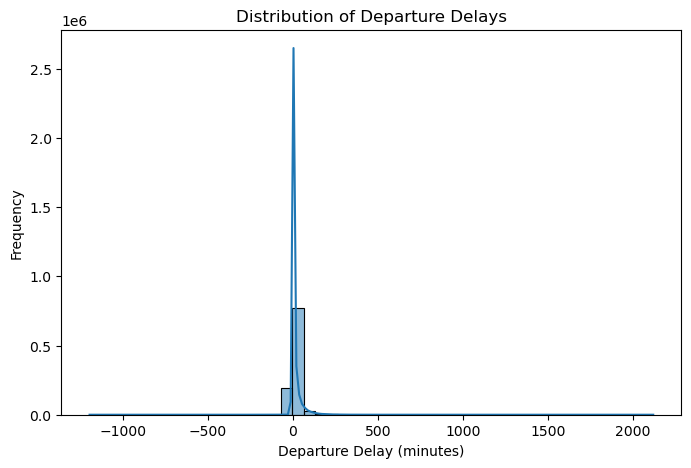

In [19]:
# Plot distribution of Departure Delays
plt.figure(figsize=(8, 5), dpi=100)
sns.histplot(df["DepDelay"], bins=50, kde=True)
plt.title("Distribution of Departure Delays")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")
plt.show()